# Notebook configuration

In [12]:
run_number    = 5863
save_plots    = True
plots_format  = "pdf"
outputfolder  = "plots/{}/".format(run_number)

# It's mandatory to have path sctructure as: /what/ever/this/path/is/RUN_NUMBER/ and just the files you want to
# use in this folder. If it's not the case, you should implement proper changes
input_path    = "/Users/brais/Documents/NEXT/Datos/Kr_lt/{0}/".format(run_number)

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Erange_raw    =   3e3, 15e3

E0guess       = 13e3
Ltguess       = 1000
R_fiducial    = 50
Z_fiducial    = 10 , 570
Zrange_DV     = 500, 600
nslices       = 20
nStimeprofile = 1800



In [13]:
import os
import glob
#import shutil
#import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import matplotlib.dates  as md
import datetime

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf

import invisible_cities.reco.corrections    as corrf
import invisible_cities.io  .dst_io         as dstio

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.core.stat_functions import poisson_sigma



from invisible_cities.icaro.hst_functions import plot_writer

pi   = np.pi
save = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None

Running on  Mon Jun 18 15:13:41 2018


### General ploting options

In [14]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [15]:
full = dstio.load_dsts(glob.glob(input_path + '*h5'), "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

1209037


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,1116021,1.529196e+09,0,0,1,1,175.0,2.107008,10.105659,536100.0,...,20,116.395256,116.395256,1.058606,-84.957147,-122.269721,148.887882,-2.178047,28.890614,20.512298
1,1116022,1.529196e+09,0,0,1,1,100.0,1.829953,6.108021,101475.0,...,19,553.000793,553.000793,2.187143,76.232893,71.069681,104.222616,0.750361,36.493012,41.341955
2,1116023,1.529196e+09,0,0,1,1,225.0,2.588907,14.453738,595150.0,...,23,57.301941,57.301941,0.790530,-21.985350,-96.243029,98.722218,-1.795379,31.553779,10.844797
3,1116024,1.529196e+09,0,0,1,1,150.0,5.718956,23.093748,497525.0,...,23,154.977875,154.977875,1.268382,64.365739,169.848918,181.635909,1.208559,21.580506,33.798127
4,1116025,1.529196e+09,0,0,1,1,200.0,2.671946,15.457053,397950.0,...,21,255.548325,255.548325,1.563690,-30.851648,-76.006892,82.029701,-1.956384,52.459812,14.624416


In [16]:
fid = full
fid = fid[fid.R < R_fiducial] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.06473581867221599


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
9,1116029,1.529196e+09,0,0,1,1,125.0,2.228944,9.481476,122525.0,...,20,530.978088,530.978088,2.283895,-9.103964,-18.882342,20.962466,-2.020055,42.630459,29.145072
24,1116052,1.529196e+09,0,0,1,1,175.0,2.808993,13.671556,240300.0,...,20,413.209595,413.209595,1.973298,-8.990914,-46.658039,47.516410,-1.761161,50.970188,19.446958
34,1116063,1.529196e+09,0,0,1,1,275.0,1.472816,13.763200,185575.0,...,20,467.910706,467.910706,2.037511,23.644038,6.463988,24.511705,0.266867,49.289134,29.118828
46,1116085,1.529196e+09,0,0,1,1,325.0,1.345080,11.744434,385525.0,...,19,267.968964,267.968964,1.639308,1.356336,-33.264976,33.292616,-1.530045,25.018771,9.409370
47,1116086,1.529196e+09,0,0,1,1,125.0,2.249810,10.347129,296850.0,...,20,355.651886,355.651886,1.832010,-16.080360,19.877159,25.567156,2.250993,31.796394,17.711581


# Lifetime computation

### General plots

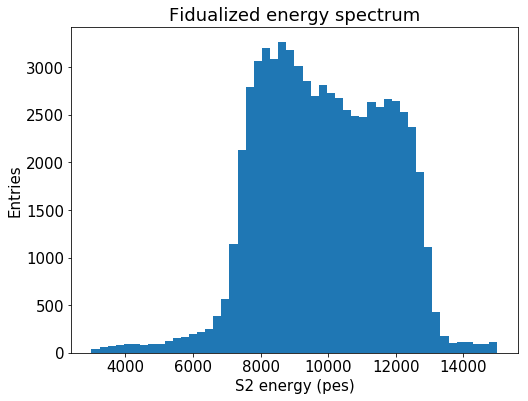

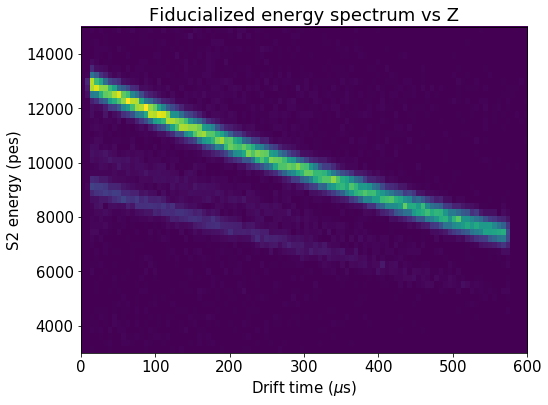

In [17]:
hist(fid.S2e, 50, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("Raw_energy_fiducial")


hist2d(fid.Z, fid.S2e, (100, 50), range=(Zrange, Erange_raw))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("Raw_energy_vsZ_fiducial")


## Computation

In [18]:
# Data selection

data = fid

Zbins = np.linspace(*Z_fiducial, nslices)
Zcorr = corrf.LifetimeCorrection(-Ltguess, E0guess)


Z_drift_data = []
for i in range(len(Zbins)-1):
    zpos    = np.mean([Zbins[i], Zbins[i+1]])
    data_   = data[coref.in_range(data.Z.values, Zbins[i], Zbins[i+1])]
    E_zcorr = data_.S2e.values 
    
    y, x    = np.histogram(E_zcorr, 50, range=Erange_raw)
    x       = shift_to_bin_centers(x)
    seed = 1e4,  E0guess*Zcorr(zpos).value, 200 
    f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=Erange_raw)
    Z_drift_data.append([f.values[1],f.errors[1]])


Energy at z=0 = 13078.2 +- 4.5
Lifetime      = 996.251 +- 0.782
Chi2          = 8.72          


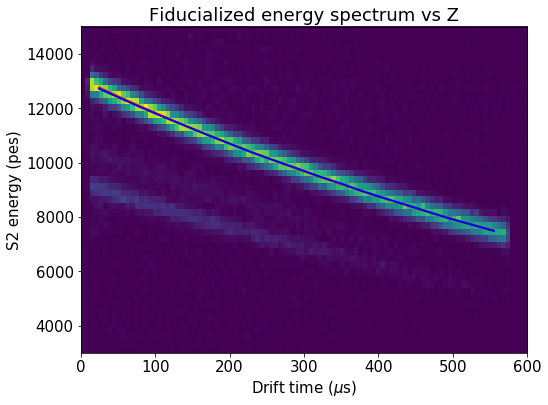

In [19]:
E_z = data.S2e 
hist2d(data.Z, E_z, (100, 50), range=(Zrange, Erange_raw))

x, y, u_y = map(np.array, [Zbins, *zip(*Z_drift_data)])
x = shift_to_bin_centers(x)

plt.errorbar(x, y, yerr=u_y, fmt='b', linewidth=2)

seed = E0guess, -Ltguess
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Z_fiducial, sigma=u_y)

E0mean, Ltmean = f.values 

plt.plot(x, f.fn(x), c='r', linewidth=2)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.3f} +- {:.3f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

### time profile

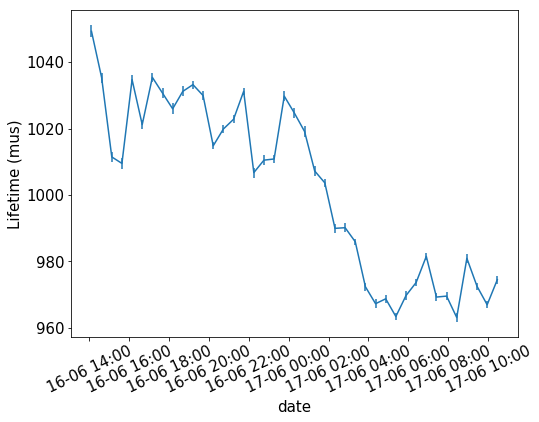

In [21]:
data = fid
data = data.sort_values('event')

tstart = data.time.values[ 0]
tfinal = data.time.values[-1]

nStimeprofile

ntimebins = int( np.floor( ( tfinal - tstart) / nStimeprofile) )
ntimebins = np.max([ntimebins, 1])

tbins = np.linspace( tstart, tfinal, ntimebins+1)
time, lt, elt = [], [], []

for t in range(ntimebins):
    data_time = data[coref.in_range(data.time, tbins[t], tbins[t+1])]
    Zbins = np.linspace(*Z_fiducial, nslices)
    Zcorr = corrf.LifetimeCorrection(Ltmean, E0mean)
    Z_drift_data = []
    for i in range(len(Zbins)-1):
        zpos    = np.mean([Zbins[i], Zbins[i+1]])
        data_   = data_time[coref.in_range(data_time.Z.values, Zbins[i], Zbins[i+1])]
        E_zcorr = data_.S2e.values 

        y, x    = np.histogram(E_zcorr, 50, range=Erange_raw)
        x       = shift_to_bin_centers(x)
        seed = 1e4,  E0guess*Zcorr(zpos).value, 100 
        f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=Erange_raw)
        Z_drift_data.append([f.values[1],f.errors[1]])
    x, y, u_y = map(np.array, [Zbins, *zip(*Z_drift_data)])
    x = shift_to_bin_centers(x)
    
    #plt.figure()
    #hist2d(data_time.Z, data_time.S2e, (100, 50), range=(Zrange, Erange_raw))
    #plt.errorbar(x,y)
    
    seed = E0mean, Ltmean
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Z_fiducial, sigma=u_y)
    time.append(np.mean([tbins[t],tbins[t+1]]))
    lt  .append(-f.values[1])
    elt .append(-f.errors[1])


time_ = list(map(datetime.datetime.fromtimestamp, time))

plt.figure()
ax=plt.gca()
xfmt = md.DateFormatter('%d-%m %H:%M')
ax.xaxis.set_major_formatter(xfmt)    

plt.errorbar(time_, lt, elt)
plt.xlabel('date')
plt.ylabel('Lifetime (mus)')
plt.xticks( rotation=25 )
save("LifetimevsDate")


# Drift velocity

Max drift length = 573.277 +- 0.169
Drift velocity   = 0.92486 +- 0.00027


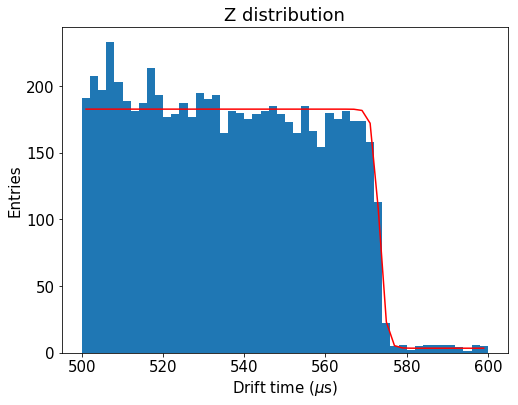

In [22]:
data = fid
y, x, _ = hist(data.Z, 50, Zrange_DV)
 
sigmoid  = lambda x, A, B, C, D: A/(1 + np.exp(-C*(x-B))) + D
seed     = np.max(y), np.mean(Zrange_DV), np.diff(Zrange_DV)[0]/100, np.min(y)
f        = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y), fit_range=Zrange_DV)

dv   = 530.2/f.values[1]
u_dv =  dv/f.values[1] * f.errors[1]

plt.plot(x, f.fn(x), fitOpt)

labels("Drift time ($\mu$s)", "Entries", "Z distribution")
print("Max drift length = {:.3f} +- {:.3f}".format(f.values[1], f.errors[1]))
print("Drift velocity   = {:.5f} +- {:.5f}".format(dv, u_dv))
save("Drift_velocity")